# Import thư viện

In [1]:
import warnings
import os
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor, KerasClassifier

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

# Dữ liệu

In [2]:
df = pd.read_csv("batdongsan_data.csv")
df.head()

,Địa chỉ,Phường/Xã/Thị trấn,Quận/Huyện,Diện tích,Mức giá,Giá tiền,Mặt tiền,Đường vào,Hướng nhà,Hướng ban công,Số tầng,Số phòng ngủ,Số toilet,Pháp lý,Nội thất
0,"Đường Đại Kim, Phường Đại Kim, Hoàng Mai, Hà Nội",Phường Đại Kim,Hoàng Mai,62 m²,20.5 tỷ,330.64 triệu/m²,4 m,8 m,Đông - Bắc,Nam,4 tầng,6 phòng,4 phòng,Đã có sổ đỏ,Cơ bản.
1,"Đường Âu Cơ, Phường Nhật Tân, Tây Hồ, Hà Nội",Phường Nhật Tân,Tây Hồ,10 m²,15.5 tỷ,147.62 triệu/m²,4.1 m,5 m,Đông - Bắc,Tây - Nam,5 tầng,4 phòng,4 phòng,Đã có sổ đỏ,Cơ bản
2,"Ngõ An Trạch 1, Phố An Trạch, Phường Quốc Tử...",Phường Quốc Tử Giám,Đống Đa,48 m²,8.8 tỷ,183.33 triệu/m²,4.7 m,NaN,Bắc,Đông - Bắc,4 tầng,4 phòng,3 phòng,Đã có sổ đỏ,Đầy đủ
3,"Phường Cổ Nhuế 2, Bắc Từ Liêm, Hà Nội",Phường Cổ Nhuế 2,Bắc Từ Liêm,55 m²,6.4 tỷ,116.36 triệu/m²,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Đã có sổ đỏ,NaN
4,"Thị trấn Trạm Trôi, Hoài Đức, Hà Nội",Thị trấn Trạm Trôi,Hoài Đức,30 m²,4.2 tỷ,140 triệu/m²,6.3 m,3.5 m,Đông - Bắc,Đông,5 tầng,3 phòng,4 phòng,Đã có sổ đỏ,Đầy đủ


# The total records of the dataset


In [3]:
print("The total records of the dataset are: ", str(len(df)), "records.")


The total records of the dataset are:  23690 records.


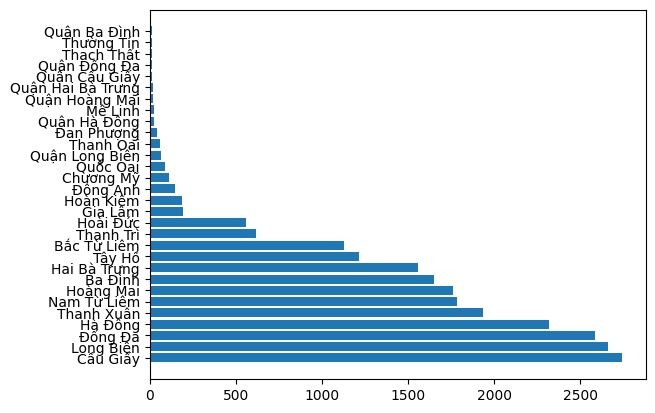

In [4]:
x = df['Quận/Huyện'].value_counts().keys()

plt.barh(x[:30], df['Quận/Huyện'].value_counts()[:30]);

<Axes: xlabel='Mức giá', ylabel='Count'>

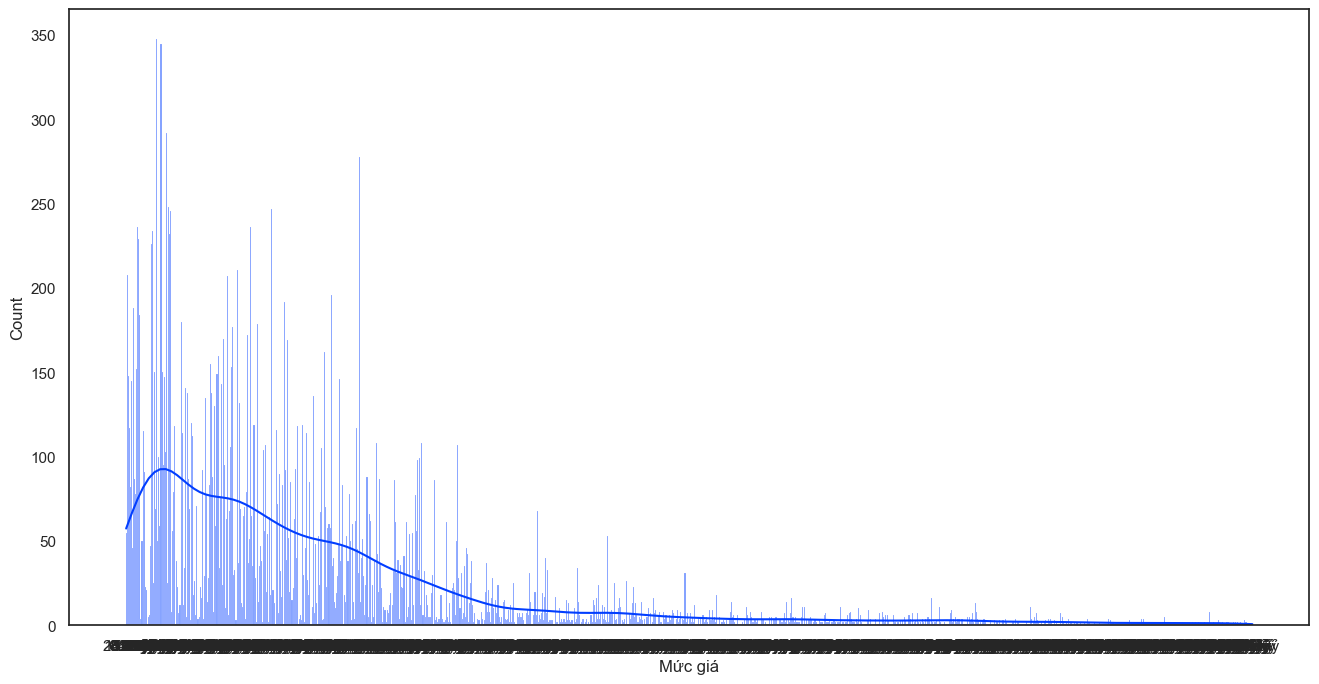

In [5]:
x= df['Mức giá'].describe()

sns.set_theme(style="white", palette="bright", rc={'figure.figsize': (16, 8)})
sns.histplot(df['Mức giá'],kde=True)

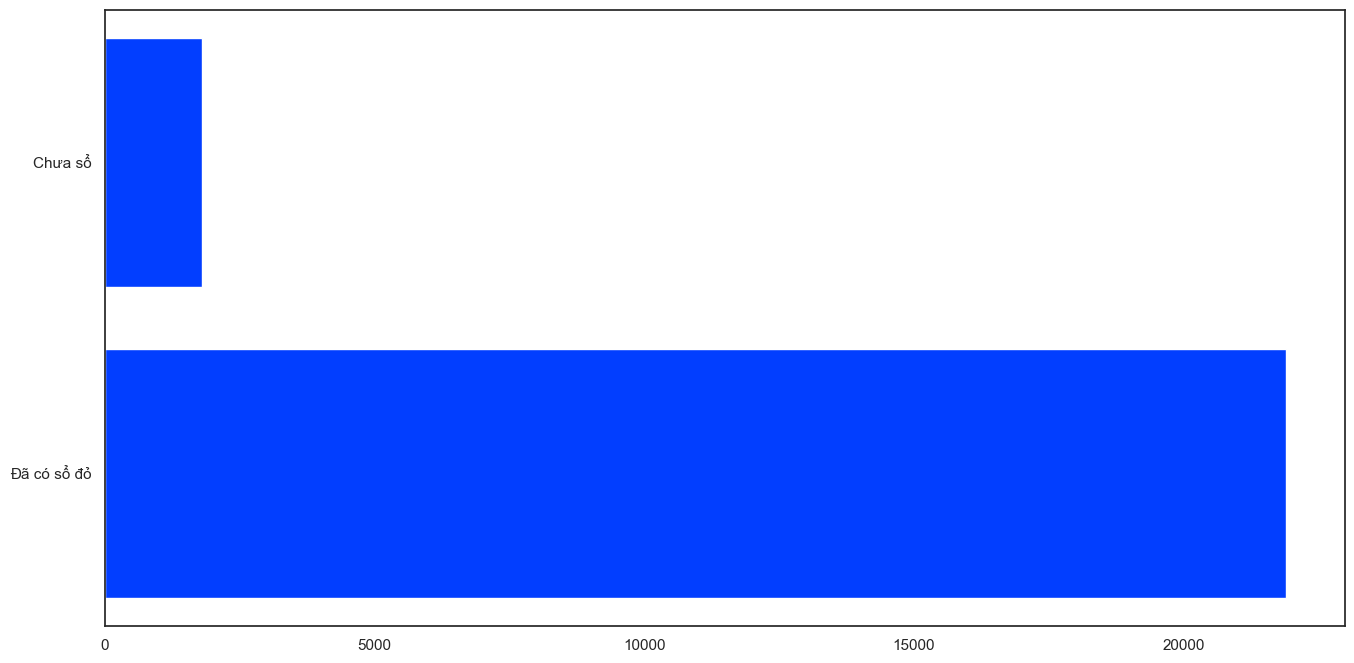

In [6]:
x = df['Pháp lý'].value_counts()
plt.barh(x.keys(), x);

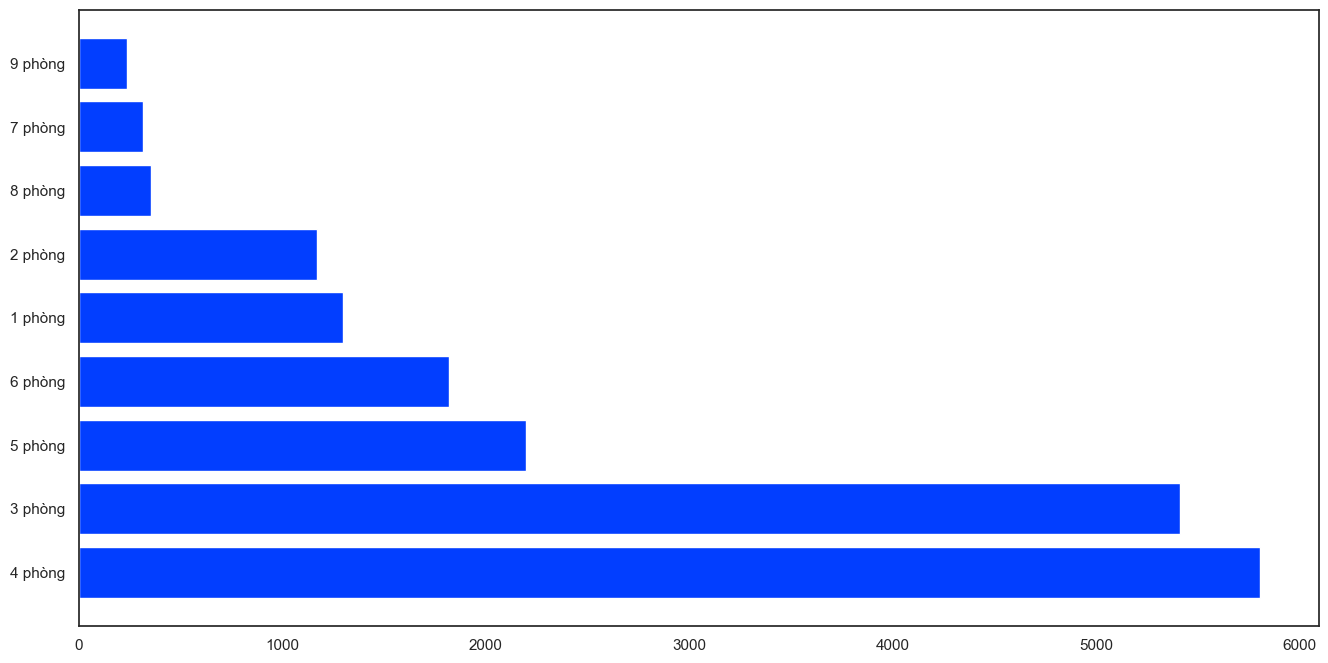

In [7]:
x = df['Số phòng ngủ'].value_counts()
plt.barh(x.keys(), x);

# Cleaning data and removing outliers

In [8]:
df = df.rename(columns = {"Địa chỉ":"address", "Phường/Xã/Thị trấn":"ward", "Quận/Huyện":"district", "Diện tích":"squared_meter_area", "Mức giá": "house_price", "Giá tiền":"price_in_million_per_square_meter", "Mặt tiền":"facade_meter", "Đường vào":"Driveway","Hướng nhà":"house_direction","Hướng ban công":"balcony_direction","Số tầng":"num_floors", "Số tầng":"num_floors",
                                 "Số phòng ngủ":"num_bed_rooms", "Số toilet":"num_toilet","Pháp lý":"legal_paper", "Nội thất":"furniture"})

In [9]:
df.head()


,address,ward,district,squared_meter_area,house_price,price_in_million_per_square_meter,facade_meter,Driveway,house_direction,balcony_direction,num_floors,num_bed_rooms,num_toilet,legal_paper,furniture
0,"Đường Đại Kim, Phường Đại Kim, Hoàng Mai, Hà Nội",Phường Đại Kim,Hoàng Mai,62 m²,20.5 tỷ,330.64 triệu/m²,4 m,8 m,Đông - Bắc,Nam,4 tầng,6 phòng,4 phòng,Đã có sổ đỏ,Cơ bản.
1,"Đường Âu Cơ, Phường Nhật Tân, Tây Hồ, Hà Nội",Phường Nhật Tân,Tây Hồ,10 m²,15.5 tỷ,147.62 triệu/m²,4.1 m,5 m,Đông - Bắc,Tây - Nam,5 tầng,4 phòng,4 phòng,Đã có sổ đỏ,Cơ bản
2,"Ngõ An Trạch 1, Phố An Trạch, Phường Quốc Tử...",Phường Quốc Tử Giám,Đống Đa,48 m²,8.8 tỷ,183.33 triệu/m²,4.7 m,NaN,Bắc,Đông - Bắc,4 tầng,4 phòng,3 phòng,Đã có sổ đỏ,Đầy đủ
3,"Phường Cổ Nhuế 2, Bắc Từ Liêm, Hà Nội",Phường Cổ Nhuế 2,Bắc Từ Liêm,55 m²,6.4 tỷ,116.36 triệu/m²,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Đã có sổ đỏ,NaN
4,"Thị trấn Trạm Trôi, Hoài Đức, Hà Nội",Thị trấn Trạm Trôi,Hoài Đức,30 m²,4.2 tỷ,140 triệu/m²,6.3 m,3.5 m,Đông - Bắc,Đông,5 tầng,3 phòng,4 phòng,Đã có sổ đỏ,Đầy đủ


In [10]:
df = df.drop_duplicates(keep='first')


# Filtering duplicates


In [11]:
print("The total records of the dataset are: ", str(len(df)), "records.")


The total records of the dataset are:  23654 records.


In [12]:
df = df.drop(['furniture'], axis=1)

In [13]:
df = df.dropna()
df = df.reset_index()
print("The total records of the dataset are: ", str(len(df)), "records.")

The total records of the dataset are:  7738 records.


In [14]:
df['ward'] = df['ward'].str.replace('Phường ','').str.strip()
df['district'] = df['district'].str.replace('Quận ','').str.strip()
df['squared_meter_area'] = df['squared_meter_area'].str.replace(' m²','').str.strip().astype(float)
df['house_price'] = df['house_price'].str.replace('tỷ', '').str.strip().astype(float)
df['facade_meter'] = df['facade_meter'].str.replace(' m','').str.strip().astype(float)
df['num_floors'] = df['num_floors'].str.replace('tầng', '').str.strip().astype(float)
df['num_bed_rooms'] = df['num_bed_rooms'].str.replace(' phòng','').str.strip().astype(float)
df['num_toilet'] = df['num_toilet'].str.replace(' phòng','').str.strip().astype(float)


In [15]:
df.head()

,index,address,ward,district,squared_meter_area,house_price,price_in_million_per_square_meter,facade_meter,Driveway,house_direction,balcony_direction,num_floors,num_bed_rooms,num_toilet,legal_paper
0,0,"Đường Đại Kim, Phường Đại Kim, Hoàng Mai, Hà Nội",Đại Kim,Hoàng Mai,62.0,20.5,330.64 triệu/m²,4.0,8 m,Đông - Bắc,Nam,4.0,6.0,4.0,Đã có sổ đỏ
1,1,"Đường Âu Cơ, Phường Nhật Tân, Tây Hồ, Hà Nội",Nhật Tân,Tây Hồ,10.0,15.5,147.62 triệu/m²,4.1,5 m,Đông - Bắc,Tây - Nam,5.0,4.0,4.0,Đã có sổ đỏ
2,4,"Thị trấn Trạm Trôi, Hoài Đức, Hà Nội",Thị trấn Trạm Trôi,Hoài Đức,30.0,4.2,140 triệu/m²,6.3,3.5 m,Đông - Bắc,Đông,5.0,3.0,4.0,Đã có sổ đỏ
3,11,"Đường Âu Cơ, Phường Nhật Tân, Tây Hồ, Hà Nội",Nhật Tân,Tây Hồ,55.0,12.0,218.18 triệu/m²,4.2,4 m,Nam,Đông - Bắc,7.0,4.0,5.0,Đã có sổ đỏ
4,13,"Phố Chùa Quỳnh, Phường Quỳnh Lôi, Hai Bà Trưng...",Quỳnh Lôi,Hai Bà Trưng,40.0,6.2,155 triệu/m²,4.1,3 m,Đông - Bắc,Tây,5.0,3.0,4.0,Đã có sổ đỏ


Text(0.5, 0, 'Square meter (m²)')

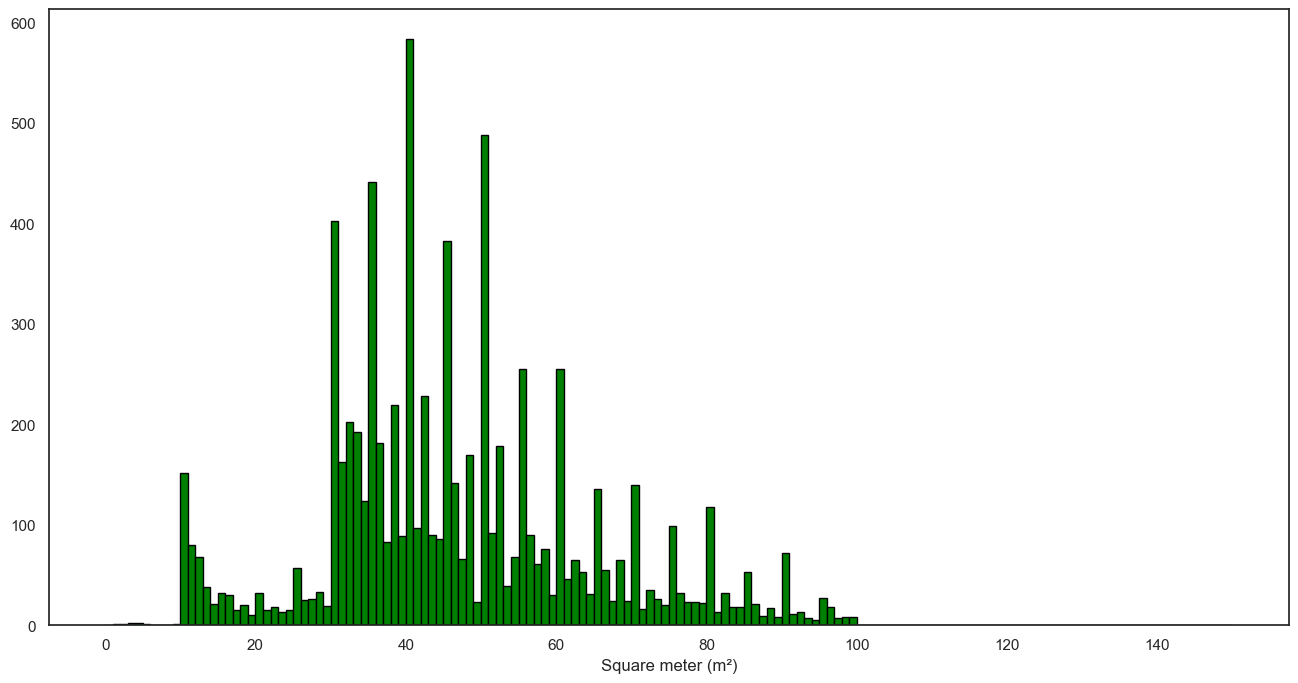

In [16]:
x = df['squared_meter_area']
plt.hist(x, edgecolor='black', color='green', bins=np.arange(0, 150+1))
plt.xlabel("Square meter (m²)")

In [17]:
result = df.groupby('price_in_million_per_square_meter').size().reset_index(name='count')
result.sort_values(by='count', ascending=False)

,price_in_million_per_square_meter,count
1411,200 triệu/m²,94
2010,250 triệu/m²,66
655,150 triệu/m²,60
2360,300 triệu/m²,48
913,166.67 triệu/m²,46
...,...,...
1337,195.38 triệu/m²,1
1336,195.35 triệu/m²,1
1334,195.2 triệu/m²,1
1333,195.18 triệu/m²,1


In [18]:
df.columns


Index(['index', 'address', 'ward', 'district', 'squared_meter_area',
       'house_price', 'price_in_million_per_square_meter', 'facade_meter',
       'Driveway', 'house_direction', 'balcony_direction', 'num_floors',
       'num_bed_rooms', 'num_toilet', 'legal_paper'],
      dtype='object')

In [19]:
dummy_ward= pd.get_dummies(df.ward, prefix="ward")
dummy_district= pd.get_dummies(df.district, prefix="district")
dummy_house_direction = pd.get_dummies(df.house_direction, prefix="house_direction")
dummy_balcony_direction = pd.get_dummies(df.balcony_direction, prefix="balcony_direction")

df_cleaned = pd.concat([df, dummy_ward, dummy_district,dummy_house_direction,dummy_balcony_direction ], axis=1)
df_cleaned = df_cleaned.drop(['index', 'address', 'district', 'ward','house_direction','balcony_direction',  'facade_meter','Driveway','legal_paper'], axis = 1)
df_cleaned = df_cleaned.replace({False: 0, True: 1})
df_cleaned.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_26636\350222806.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned = df_cleaned.replace({False: 0, True: 1})


,squared_meter_area,house_price,price_in_million_per_square_meter,num_floors,num_bed_rooms,num_toilet,ward_Bách Khoa,ward_Bạch Mai,ward_Bạch Đằng,ward_Biên Giang,...,house_direction_Đông - Bắc,house_direction_Đông - Nam,balcony_direction_Bắc,balcony_direction_Nam,balcony_direction_Tây,balcony_direction_Tây - Bắc,balcony_direction_Tây - Nam,balcony_direction_Đông,balcony_direction_Đông - Bắc,balcony_direction_Đông - Nam
0,62.0,20.5,330.64 triệu/m²,4.0,6.0,4.0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,10.0,15.5,147.62 triệu/m²,5.0,4.0,4.0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,30.0,4.2,140 triệu/m²,5.0,3.0,4.0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,55.0,12.0,218.18 triệu/m²,7.0,4.0,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,40.0,6.2,155 triệu/m²,5.0,3.0,4.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [20]:
df_cleaned.columns

Index(['squared_meter_area', 'house_price',
       'price_in_million_per_square_meter', 'num_floors', 'num_bed_rooms',
       'num_toilet', 'ward_Bách Khoa', 'ward_Bạch Mai', 'ward_Bạch Đằng',
       'ward_Biên Giang',
       ...
       'house_direction_Đông - Bắc', 'house_direction_Đông - Nam',
       'balcony_direction_Bắc', 'balcony_direction_Nam',
       'balcony_direction_Tây', 'balcony_direction_Tây - Bắc',
       'balcony_direction_Tây - Nam', 'balcony_direction_Đông',
       'balcony_direction_Đông - Bắc', 'balcony_direction_Đông - Nam'],
      dtype='object', length=306)

In [21]:
df['price_in_million_per_square_meter'] = df['price_in_million_per_square_meter'].str.replace(' triệu/m²','').str.strip().astype(float)

In [22]:
df_cleaned = df[["squared_meter_area","house_price","price_in_million_per_square_meter","num_floors","facade_meter","num_bed_rooms","num_toilet"]]
df_cleaned.head()

,squared_meter_area,house_price,price_in_million_per_square_meter,num_floors,facade_meter,num_bed_rooms,num_toilet
0,62.0,20.5,330.64,4.0,4.0,6.0,4.0
1,10.0,15.5,147.62,5.0,4.1,4.0,4.0
2,30.0,4.2,140.00,5.0,6.3,3.0,4.0
3,55.0,12.0,218.18,7.0,4.2,4.0,5.0
4,40.0,6.2,155.00,5.0,4.1,3.0,4.0


Removing outliers


In [23]:
def remove_outlier_IQR(df, series):
    Q1=df[series].quantile(0.25)
    Q3=df[series].quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df[series]<(Q1-1.5*IQR)) | (df[series]>(Q3+1.5*IQR)))]
    return df_final

removed_outliers = df_cleaned
columns_to_remove_outliers = ["squared_meter_area","house_price","price_in_million_per_square_meter","num_floors","facade_meter","num_bed_rooms","num_toilet"]
for column in columns_to_remove_outliers:
    removed_outliers = remove_outlier_IQR(removed_outliers, column)

print("The final length of the dataset is", str(len(removed_outliers)), "rows.")

The final length of the dataset is 5191 rows.


In [24]:
removed_outliers.head()


,squared_meter_area,house_price,price_in_million_per_square_meter,num_floors,facade_meter,num_bed_rooms,num_toilet
0,62.0,20.50,330.64,4.0,4.0,6.0,4.0
1,10.0,15.50,147.62,5.0,4.1,4.0,4.0
2,30.0,4.20,140.00,5.0,6.3,3.0,4.0
4,40.0,6.20,155.00,5.0,4.1,3.0,4.0
5,52.0,12.99,246.49,4.0,4.0,4.0,3.0


In [25]:
housing = removed_outliers

# Separate predictors and response (price) variables
X = housing.loc[:, (housing.columns != 'price_in_million_per_square_meter')]
y = housing[['price_in_million_per_square_meter']]
to_be_scaled = ['squared_meter_area','house_price','num_floors','facade_meter','num_bed_rooms','num_toilet']

# Initiate scaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

X_scaled = X
y_scaled = y

# Storing the fit object for reference and reverse the scaling later
PredictorScalerFit=PredictorScaler.fit(X_scaled[to_be_scaled])
TargetVarScalerFit=TargetVarScaler.fit(y_scaled)

# Generating the standardized values of X and y
X_scaled[to_be_scaled]=PredictorScalerFit.transform(X_scaled[to_be_scaled])
y_scaled=TargetVarScalerFit.transform(y)

X_array = np.array(X_scaled.values).astype("float32")
y_array = np.array(y_scaled).astype("float32")

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array,
                                                    test_size=0.2,
                                                    random_state=2023)

# Sanity check to see if all train and test arrays have correct dimensions
assert X_train.shape[0] == y_train.shape[0] and X_train.shape[1] == X_test.shape[1] and X_test.shape[0] == y_test.shape[0] and y_train.shape[1] == y_test.shape[1], \
"All train and test sets should have correct dimensions."

C:\Users\Admin\AppData\Local\Temp\ipykernel_26636\4105690029.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_scaled[to_be_scaled]=PredictorScalerFit.transform(X_scaled[to_be_scaled])


In [26]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(4152, 6) (1039, 6) (4152, 1) (1039, 1)


Using Traditional Linear Regression in Statistics


In [27]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [28]:
r_sq = model.score(X_train, y_train)
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.7286301851272583


In [29]:
y_pred = model.intercept_ + np.sum(model.coef_ * X_test, axis=1)
print("The prediction of the statistical Linear Regression model:\n", y_pred)

The prediction of the statistical Linear Regression model:
 [-0.00286224 -0.335262   -0.9454535  ... -0.52064717 -0.47582096
 -0.91871923]


In [30]:
from sklearn.preprocessing import PolynomialFeatures
X_train_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_train)
X_train_.shape

(4152, 27)

In [31]:
new_model = LinearRegression()
new_model.fit(X_train_, y_train)

LinearRegression()

In [32]:
r_sq = new_model.score(X_train_, y_train)
print(f"cofficient of determination: {r_sq}")

cofficient of determination: 0.9126187562942505


Neural Network

In [33]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_SETTINGS"] = "false"

# Create the base model
def create_regression_NN():
    model = Sequential()
    model.add(Dense(units=10, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Creathe a dictionary for trial parameters
NN_params = {'batch_size':[10, 20, 30, 50],
             'epochs':[10, 20, 50]}

NN_trial = KerasRegressor(create_regression_NN, verbose=1)

# Initiate the grid search and storing best parameters for later reference
NN_grid_search = GridSearchCV(estimator=NN_trial, param_grid=NN_params,
                               cv=3, n_jobs = -1).fit(X_train, y_train, verbose=1)
NN_best_params = NN_grid_search.best_params_

# Showing the best parameters
NN_best_params

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8254
Epoch 2/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2413
Epoch 3/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1373
Epoch 4/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 0.1256
Epoch 5/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 0.1015
Epoch 6/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.0957
Epoch 7/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.0792
Epoch 8/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.0686
Epoch 9/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 0.0654
Epoch 10/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.0636
Epoch 11/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 0.0594
Epoch 12/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.0573
Epoch 13/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0520
Epoch 14/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.0493
Epoch 15/50
416/416 ━━━━━━━━━━━━━━━

{'batch_size': 10, 'epochs': 50}

In [34]:
NN = Sequential()
NN.add(Dense(units=10, input_dim=X_train.shape[1],
                kernel_initializer='normal', activation='relu'))
NN.add(Dense(1, kernel_initializer='normal'))
NN.compile(loss='mean_squared_error', optimizer='adam')

NN.fit(X_train, y_train,
       batch_size = int(NN_best_params['batch_size']),
        epochs = int(NN_best_params['epochs']),
       verbose=1)

# Generating Predictions on testing data
NN_predictions = NN.predict(X_test)
# Scaling the predicted Price data back to original price scale
NN_predictions = TargetVarScalerFit.inverse_transform(NN_predictions)

# Scaling the y_test Price data back to original price scale
y_test_orig = TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
Test_Data = np.concatenate((PredictorScalerFit.inverse_transform(X_test), X_test[:,6:]), axis=1)

# Recreating the dataset, now with predicted price using the NN model
TestingData = pd.DataFrame(data=Test_Data, columns=X.columns)
TestingData['Price'] = y_test_orig
TestingData['NN_predictions'] = NN_predictions

TestingData[['Price', 'NN_predictions']].head()

Epoch 1/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.8154
Epoch 2/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2314
Epoch 3/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1335
Epoch 4/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1262
Epoch 5/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1009
Epoch 6/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0956
Epoch 7/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0853
Epoch 8/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0834
Epoch 9/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0651
Epoch 10/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0604
Epoch 11/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0575
Epoch 12/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0539
Epoch 13/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0565
Epoch 14/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 0.0447
Epoch 15/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step 

,Price,NN_predictions
0,171.050003,176.520523
1,157.500000,159.528046
2,110.000000,114.212471
3,272.500000,275.041321
4,116.249992,113.579689


In [35]:
r2_nn = r2_score(y_test_orig, NN_predictions)
mae_nn = mean_absolute_error(y_test_orig, NN_predictions)
rmse_nn = np.sqrt(mean_squared_error(y_test_orig, NN_predictions))
print("R² của Neural Network:", r2_nn)
print("MAE của Neural Network:", mae_nn)
print("RMSE của Neural Network:", rmse_nn)

R² của Neural Network: 0.9723870158195496
MAE của Neural Network: 6.451794
RMSE của Neural Network: 10.038887


 Random Forest 
 

In [36]:
RF_random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
               'max_features': ['sqrt', 'log2',None],
               'max_depth': [int(x) for x in np.linspace(10, 100, num = 10)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [37]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_SETTINGS"] = "false"

# Create the base RF model and fit the random search
RF_regressor = RandomForestRegressor()
RF_random_search = RandomizedSearchCV(estimator=RF_regressor, param_distributions=RF_random_grid, n_iter=50, cv=5,
                                      verbose=1, random_state=2022, n_jobs = -1).fit(X_train, np.ravel(y_train))
RF_best_params = RF_random_search.best_params_
RF_best_params

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 80,
 'bootstrap': True}

In [38]:
RF_param_grid = {'n_estimators': [RF_best_params['n_estimators']-100, RF_best_params['n_estimators']],
               'max_features': ['sqrt', 'log2'],
               'max_depth': [RF_best_params['max_depth'] - 10, RF_best_params['max_depth']],
               'min_samples_split': [5, 10],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [39]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_SETTINGS"] = "false"

# Create another base RF model and fit the grid search
RF_regressor_2 = RandomForestRegressor()
RF_grid_search = GridSearchCV(estimator=RF_regressor_2, param_grid=RF_param_grid,
                              cv=5, n_jobs=-1, verbose=4).fit(X_train, np.ravel(y_train))

# Showing the best parameters
RF_grid_search.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 600}

In [40]:
RF = RF_grid_search.best_estimator_

# Generating Predictions on testing data
RF_predictions = RF.predict(X_test)

RF_predictions = TargetVarScalerFit.inverse_transform(RF_predictions.reshape(-1, 1))

# Ensure that RF_predictions length matches TestingData
TestingData['RF_predictions'] = RF_predictions[:len(TestingData)]

In [41]:
r2_rf = r2_score(y_test_orig, RF_predictions)
mae_rf = mean_absolute_error(y_test_orig, RF_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test_orig, RF_predictions))

# Hiển thị kết quả
print("R² của Random Forest:", r2_rf)
print("MAE của Random Forest:", mae_rf)
print("RMSE của Random Forest:", rmse_rf)

R² của Random Forest: 0.9718058847432185
MAE của Random Forest: 5.644449831405011
RMSE của Random Forest: 10.14396939583327


In [42]:
TestingData[['Price', 'NN_predictions','RF_predictions']].head()

,Price,NN_predictions,RF_predictions
0,171.050003,176.520523,176.916160
1,157.500000,159.528046,157.812354
2,110.000000,114.212471,107.083523
3,272.500000,275.041321,265.957426
4,116.249992,113.579689,114.824371


Linear Regression

In [43]:
print(f"cofficient of determination: {r_sq}")

cofficient of determination: 0.9126187562942505


In [56]:
LR_predictions = model.predict(X_test)
LR_predictions = TargetVarScalerFit.inverse_transform(LR_predictions)
TestingData['LR_predictions'] = LR_predictions
r2 = r2_score(y_test_orig, LR_predictions)
mae = mean_absolute_error(y_test_orig, LR_predictions)
rmse = np.sqrt(mean_squared_error(LR_predictions, y_test_orig))

In [57]:
print("R² của Linear Regression:", r2)
print("MAE của Linear Regression:", mae)
print("RMSE của Linear Regression:", rmse)

R² của Linear Regression: 0.7221488952636719
MAE của Linear Regression: 19.531263
RMSE của Linear Regression: 31.844526


In [46]:
TestingData['NN_predictions'] = NN_predictions
TestingData['RF_predictions'] = RF_predictions  
TestingData['LR_predictions'] = LR_predictions


In [47]:
TestingData[['Price', 'NN_predictions', 'RF_predictions', 'LR_predictions']].head()


,Price,NN_predictions,RF_predictions,LR_predictions
0,171.050003,176.520523,176.916160,185.199127
1,157.500000,159.528046,157.812354,164.728058
2,110.000000,114.212471,107.083523,127.148972
3,272.500000,275.041321,265.957426,233.926056
4,116.249992,113.579689,114.824371,138.759232


In [48]:
def Accuracy_Score(orig, pred):
    MAPE = np.mean(100 * (np.abs(orig - pred) / orig))
    return(100 - MAPE)

In [49]:
print("Accuracy for the NN model is:", str(Accuracy_Score(TestingData['Price'], TestingData['NN_predictions'])))
print("Accuracy for the RF model is:", str(Accuracy_Score(TestingData['Price'], TestingData['RF_predictions'])))
print("Accuracy for the LR model is:", str(Accuracy_Score(TestingData['Price'], TestingData['LR_predictions'])))

Accuracy for the NN model is: 95.66811561584473
Accuracy for the RF model is: 96.46585325283972
Accuracy for the LR model is: 88.23744773864746
